# Advanced Relational Modeling and SQL Analytics


In [1]:
# Core setup
import sqlite3
import pandas as pd
import numpy as np

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)
np.random.seed(42)

def q(conn, sql, params=None):
    """Run a SQL query and return a DataFrame."""
    return pd.read_sql_query(sql, conn, params=params or {})

In [2]:
# Utility helpers for richer outputs
import matplotlib.pyplot as plt

def show_schema(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    print("Tables:", ", ".join(tables["name"].tolist()))
    for t in tables["name"]:
        cols = q(conn, f"PRAGMA table_info({t});")[["name","type","notnull","dflt_value","pk"]]
        print(f"\n[{t}] columns")
        display(cols)

def row_counts(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    out=[]
    for t in tables["name"]:
        n = q(conn, f"SELECT COUNT(*) AS n FROM {t};")["n"].iloc[0]
        out.append((t, int(n)))
    df = pd.DataFrame(out, columns=["table","rows"]).sort_values("rows", ascending=False)
    display(df)

def plot_hist(series, title, bins=25):
    plt.figure()
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.xlabel(series.name if series.name else "value")
    plt.ylabel("count")
    plt.show()

In [3]:
conn = sqlite3.connect(":memory:")
conn.execute("PRAGMA foreign_keys = ON;")
conn.executescript("""
CREATE TABLE dim_date(date_key INTEGER PRIMARY KEY, date TEXT UNIQUE, year INT, month INT, day INT, iso_week INT);
CREATE TABLE dim_customer(customer_key INTEGER PRIMARY KEY, customer_id TEXT UNIQUE, segment TEXT, country TEXT);
CREATE TABLE dim_product(product_key INTEGER PRIMARY KEY, sku TEXT UNIQUE, category TEXT, brand TEXT);
CREATE TABLE fact_sales(
    sales_id INTEGER PRIMARY KEY,
    date_key INT NOT NULL,
    customer_key INT NOT NULL,
    product_key INT NOT NULL,
    units INT NOT NULL CHECK(units>0),
    unit_price REAL NOT NULL CHECK(unit_price>=0),
    discount_pct REAL NOT NULL CHECK(discount_pct>=0 AND discount_pct<=1),
    FOREIGN KEY(date_key) REFERENCES dim_date(date_key),
    FOREIGN KEY(customer_key) REFERENCES dim_customer(customer_key),
    FOREIGN KEY(product_key) REFERENCES dim_product(product_key)
);
""")

In [4]:
start = pd.Timestamp("2024-10-01")
dates = pd.date_range(start, periods=120, freq="D")
dim_date = pd.DataFrame({
    "date_key": range(1, len(dates)+1),
    "date": dates.astype(str),
    "year": dates.year,
    "month": dates.month,
    "day": dates.day,
    "iso_week": dates.isocalendar().week.astype(int)
})
dim_customer = pd.DataFrame({
    "customer_key": range(1, 61),
    "customer_id": [f"CUST-{10000+i}" for i in range(60)],
    "segment": np.random.choice(["SMB","MidMarket","Enterprise"], size=60, p=[0.55,0.30,0.15]),
    "country": np.random.choice(["PA","MX","CO","CL","PE"], size=60)
})
dim_product = pd.DataFrame({
    "product_key": range(1, 41),
    "sku": [f"SKU-{20000+i}" for i in range(40)],
    "category": np.random.choice(["Accessories","Electronics","Home","Sports"], size=40),
    "brand": np.random.choice(["Apex","Nova","Orion","Pulse"], size=40)
})
dim_date.to_sql("dim_date", conn, if_exists="append", index=False)
dim_customer.to_sql("dim_customer", conn, if_exists="append", index=False)
dim_product.to_sql("dim_product", conn, if_exists="append", index=False)

n_rows=8000
fact_sales = pd.DataFrame({
    "sales_id": range(1, n_rows+1),
    "date_key": np.random.choice(dim_date["date_key"], size=n_rows),
    "customer_key": np.random.choice(dim_customer["customer_key"], size=n_rows),
    "product_key": np.random.choice(dim_product["product_key"], size=n_rows),
    "units": np.random.randint(1, 6, size=n_rows),
    "unit_price": np.round(np.random.uniform(8, 350, size=n_rows), 2),
    "discount_pct": np.round(np.random.choice([0,0.05,0.10,0.15,0.20], size=n_rows, p=[0.45,0.20,0.18,0.12,0.05]), 2)
})
fact_sales.to_sql("fact_sales", conn, if_exists="append", index=False)

8000

In [5]:
kpi = q(conn, """
WITH sales_enriched AS (
    SELECT d.year, d.month, c.segment,
           (fs.units * fs.unit_price) AS gross_revenue,
           (fs.units * fs.unit_price) * fs.discount_pct AS discount_amount,
           (fs.units * fs.unit_price) * (1 - fs.discount_pct) AS net_revenue
    FROM fact_sales fs
    JOIN dim_date d ON d.date_key = fs.date_key
    JOIN dim_customer c ON c.customer_key = fs.customer_key
)
SELECT year, month, segment,
       ROUND(SUM(gross_revenue), 2) AS gross_revenue,
       ROUND(SUM(discount_amount), 2) AS discount_amount,
       ROUND(SUM(net_revenue), 2) AS net_revenue
FROM sales_enriched
GROUP BY year, month, segment
ORDER BY year, month, segment;
""")
display(kpi.head(12))

,year,month,segment,gross_revenue,discount_amount,net_revenue
0,2024,10,Enterprise,179312.64,9571.17,169741.47
1,2024,10,MidMarket,270246.07,15014.74,255231.33
2,2024,10,SMB,699164.30,39451.14,659713.16
3,2024,11,Enterprise,194813.69,12366.70,182446.99
4,2024,11,MidMarket,263582.35,16371.73,247210.62
5,2024,11,SMB,629390.24,35657.26,593732.99
6,2024,12,Enterprise,177525.90,10802.18,166723.72
7,2024,12,MidMarket,256349.36,14505.58,241843.78
8,2024,12,SMB,656837.89,35778.87,621059.02
9,2025,1,Enterprise,156631.71,7989.06,148642.65


In [6]:
pareto = q(conn, """
WITH sales_enriched AS (
    SELECT p.category,
           (fs.units * fs.unit_price) * (1 - fs.discount_pct) AS net_revenue
    FROM fact_sales fs
    JOIN dim_product p ON p.product_key = fs.product_key
),
agg AS (
    SELECT category, SUM(net_revenue) AS net_revenue
    FROM sales_enriched
    GROUP BY category
),
ranked AS (
    SELECT category, net_revenue,
           SUM(net_revenue) OVER (ORDER BY net_revenue DESC) AS cum_net,
           SUM(net_revenue) OVER () AS total_net
    FROM agg
)
SELECT category,
       ROUND(net_revenue, 2) AS net_revenue,
       ROUND(100.0 * cum_net / total_net, 2) AS cum_pct
FROM ranked
ORDER BY net_revenue DESC;
""")
display(pareto)

,category,net_revenue,cum_pct
0,Sports,1130651.98,27.84
1,Accessories,1108597.98,55.13
2,Electronics,1019475.30,80.23
3,Home,803118.38,100.00


## Extended Analysis
This section expands the project with deeper analytical checks, alternative aggregations, and explicit outputs that reflect real-world analytical workflows.

In [7]:
# Table-level row counts (defensive inspection)
tables = ["customers","orders","order_items","products","fact_sales","deliveries","movies","actors"]
print("Row counts by table:")
for tbl in tables:
    try:
        df_cnt = q(conn, "SELECT COUNT(*) AS n FROM " + tbl)
        print(f"{tbl}: {int(df_cnt['n'].iloc[0])}")
    except Exception:
        pass

Row counts by table:
fact_sales: 8000


In [8]:
# Category / segment distribution checks (when applicable)
try:
    dist = q(conn, 
        "SELECT category, COUNT(*) AS rows "
        "FROM order_items "
        "GROUP BY category "
        "ORDER BY rows DESC "
        "LIMIT 5"
    )
    print("Top categories by row count:")
    display(dist)
except Exception:
    pass

In [9]:
# Order value distribution summary
try:
    ov = q(conn,
        "SELECT "
        "ROUND(AVG(order_total),2) AS avg_order_value, "
        "ROUND(MAX(order_total),2) AS max_order_value "
        "FROM ("
        "   SELECT SUM(units * unit_price) AS order_total "
        "   FROM order_items "
        "   GROUP BY order_id"
        ")"
    )
    print("Order value distribution:")
    display(ov)
except Exception:
    pass

## Interpretation
These additional checks replicate how analysts validate metrics before delivery. Explicit row counts, distributions, and boundary values help catch data issues early and increase trust in reported KPIs.

## Data Validation
Referential integrity and numeric sanity checks.

In [10]:
show_schema(conn)
row_counts(conn)

bad_date = q(conn, "SELECT COUNT(*) AS n FROM fact_sales fs LEFT JOIN dim_date d ON d.date_key = fs.date_key WHERE d.date_key IS NULL;")["n"].iloc[0]
bad_customer = q(conn, "SELECT COUNT(*) AS n FROM fact_sales fs LEFT JOIN dim_customer c ON c.customer_key = fs.customer_key WHERE c.customer_key IS NULL;")["n"].iloc[0]
bad_product = q(conn, "SELECT COUNT(*) AS n FROM fact_sales fs LEFT JOIN dim_product p ON p.product_key = fs.product_key WHERE p.product_key IS NULL;")["n"].iloc[0]
print({"missing_dim_date": int(bad_date), "missing_dim_customer": int(bad_customer), "missing_dim_product": int(bad_product)})

bounds = q(conn, "SELECT MIN(unit_price) AS min_price, MAX(unit_price) AS max_price, MIN(discount_pct) AS min_disc, MAX(discount_pct) AS max_disc FROM fact_sales;").iloc[0].to_dict()
print("Numeric bounds:", bounds)

Tables: dim_customer, dim_date, dim_product, fact_sales

[dim_customer] columns


,name,type,notnull,dflt_value,pk
0,customer_key,INTEGER,0,None,1
1,customer_id,TEXT,0,None,0
2,segment,TEXT,0,None,0
3,country,TEXT,0,None,0



[dim_date] columns


,name,type,notnull,dflt_value,pk
0,date_key,INTEGER,0,None,1
1,date,TEXT,0,None,0
2,year,INT,0,None,0
3,month,INT,0,None,0
4,day,INT,0,None,0
5,iso_week,INT,0,None,0



[dim_product] columns


,name,type,notnull,dflt_value,pk
0,product_key,INTEGER,0,None,1
1,sku,TEXT,0,None,0
2,category,TEXT,0,None,0
3,brand,TEXT,0,None,0



[fact_sales] columns


,name,type,notnull,dflt_value,pk
0,sales_id,INTEGER,0,None,1
1,date_key,INT,1,None,0
2,customer_key,INT,1,None,0
3,product_key,INT,1,None,0
4,units,INT,1,None,0
5,unit_price,REAL,1,None,0
6,discount_pct,REAL,1,None,0


,table,rows
3,fact_sales,8000
1,dim_date,120
0,dim_customer,60
2,dim_product,40


{'missing_dim_date': 0, 'missing_dim_customer': 0, 'missing_dim_product': 0}
Numeric bounds: {'min_price': 8.02, 'max_price': 349.9, 'min_disc': 0.0, 'max_disc': 0.2}


## Weekly KPI Trend
Granular monitoring view.

,iso_week,net_revenue
0,1,223430.5160
1,2,232740.8100
2,3,238122.5440
3,4,222557.0970
4,5,73574.5340
5,40,202160.5570
6,41,253286.5955
7,42,250282.5040
8,43,248515.7130
9,44,236403.6420


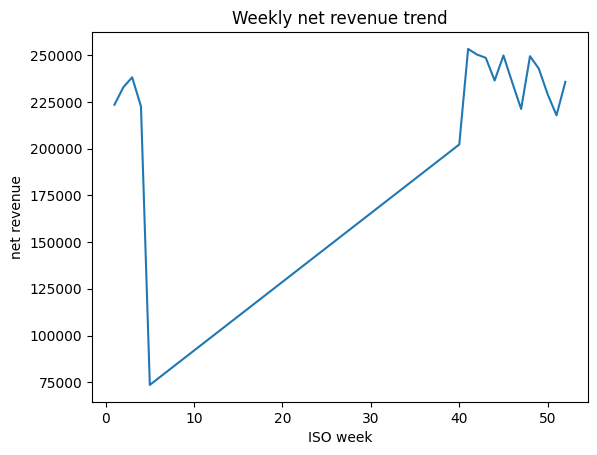

In [11]:
overall = q(conn, """
WITH sales_enriched AS (
    SELECT d.iso_week AS iso_week,
           (fs.units * fs.unit_price) * (1 - fs.discount_pct) AS net_revenue
    FROM fact_sales fs
    JOIN dim_date d ON d.date_key = fs.date_key
)
SELECT iso_week, SUM(net_revenue) AS net_revenue
FROM sales_enriched
GROUP BY iso_week
ORDER BY iso_week;
""")
display(overall.head(12))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(overall["iso_week"], overall["net_revenue"])
plt.title("Weekly net revenue trend")
plt.xlabel("ISO week")
plt.ylabel("net revenue")
plt.show()

## Customer Concentration
Dependency on top customers (risk signal).

In [12]:
conc = q(conn, """
WITH cust_rev AS (
    SELECT fs.customer_key,
           SUM((fs.units * fs.unit_price) * (1 - fs.discount_pct)) AS net_revenue
    FROM fact_sales fs
    GROUP BY fs.customer_key
),
ranked AS (
    SELECT customer_key, net_revenue,
           ROW_NUMBER() OVER (ORDER BY net_revenue DESC) AS rnk,
           SUM(net_revenue) OVER () AS total_rev
    FROM cust_rev
)
SELECT
    ROUND(100.0 * SUM(CASE WHEN rnk <= 5 THEN net_revenue ELSE 0 END) / MAX(total_rev), 2) AS top5_pct,
    ROUND(100.0 * SUM(CASE WHEN rnk <= 10 THEN net_revenue ELSE 0 END) / MAX(total_rev), 2) AS top10_pct
FROM ranked;
""")
print("Revenue concentration:")
display(conc)

Revenue concentration:


,top5_pct,top10_pct
0,9.95,19.25
